In [56]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import time
import unittest
import scipy.io

In [57]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation from scratch

## Definition of aditional functions 

### Compute mean and std for the dataset 

In [58]:
def compute_mean_std(dataset, batch_size=512, num_workers=4, pin_memory=True):
    """
    Compute the per-channel mean and std of an image dataset.

    Args:
        dataset (torch.utils.data.Dataset):
            A PyTorch Dataset whose __getitem__ returns either:
              - image Tensor of shape (C, H, W), or
              - (image Tensor, label) tuple.
            IMPORTANT: dataset.transforms must include only ToTensor()
                       (i.e. no Normalize), so images are in [0,1].
        batch_size (int): how many images to load per batch.
        num_workers (int): DataLoader num_workers for parallel loading.
        pin_memory (bool): whether to use pin_memory in DataLoader.

    Returns:
        mean (torch.Tensor): shape (3,) tensor of channel means.
        std  (torch.Tensor): shape (3,) tensor of channel stds.
    """
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=pin_memory
    )

    # We'll accumulate sum(pixel) and sum(pixel^2) over all images:
    n_channels = 3
    total_pixels = 0  # total number of pixels per channel
    sum_   = torch.zeros(n_channels)
    sum_sq = torch.zeros(n_channels)

    for batch in loader:
        # batch may be (images, labels) or just images
        images = batch[0] if isinstance(batch, (list, tuple)) else batch
        # images: (B, C, H, W)
        B, C, H, W = images.shape

        # flatten each image to (B, C, H*W)
        imgs = images.view(B, C, -1)

        # update pixel count
        total_pixels += B * H * W

        # sum over batch & pixels
        sum_   += imgs.sum(dim=[0, 2])
        sum_sq += (imgs * imgs).sum(dim=[0, 2])

    # mean = E[x]
    mean = sum_ / total_pixels

    # std = sqrt(E[x^2] - E[x]^2)
    std = torch.sqrt(sum_sq / total_pixels - mean**2)

    return mean, std

In [59]:
def svhn_label_transform(y):
    # maps MATLAB’s 10 → 0, and leaves 1–9 unchanged
    return y % 10

## Preprocessing

### Computing of mean and std

In [60]:
raw_transform = transforms.Compose([
    transforms.ToTensor()  # scale [0,255] → [0,1], channel-first
])
## here we force the dataset to be in [0,1] range to compute mean and std
raw_train_ds = datasets.SVHN(root='./data', split='train', download=True,
                             transform=raw_transform, target_transform=svhn_label_transform)

In [61]:
train_size = int(0.8 * len(raw_train_ds))   # e.g., ~58k
val_size   = len(raw_train_ds) - train_size # ~15k
train_ds, val_ds = random_split(raw_train_ds, [train_size, val_size])

In [62]:
mean, std = compute_mean_std(raw_train_ds,
                             batch_size=512,
                             num_workers=4,
                             pin_memory=True)
print("Computed SVHN mean:", mean.tolist())
print("Computed SVHN std: ", std.tolist())

Computed SVHN mean: [0.4376820921897888, 0.4437696635723114, 0.47280436754226685]
Computed SVHN std:  [0.1980302929878235, 0.20101578533649445, 0.19703631103038788]


### Transforms 

In [63]:
train_transform = transforms.Compose([
    #Padding + random crop simulates shifts
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), # simulate left-right variation
    transforms.RandomRotation(10),  
    # Color jitter for brightness/contrast/saturation
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),                          # scale [0,255]→[0,1], and (H,W,C)→(C,H,W)
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

### Datasets with full transforms 

In [64]:
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = test_transform
test_ds  = datasets.SVHN(root='./data', split='test',  download=True,
                        transform=test_transform, target_transform=svhn_label_transform)

### Dataloaders

In [65]:
batch_size = 128
num_workers = 4   # use multiple CPU cores
pin_memory  = True  # faster GPU transfers

train_loader = DataLoader(train_ds,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=pin_memory)

val_loader   = DataLoader(val_ds,
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)

test_loader = DataLoader(test_ds,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=pin_memory)


### Cnn architecture from scratch 

In [66]:
class ScratchCNN(nn.Module):
    def __init__(self):
        super(ScratchCNN, self).__init__()
        # Block 1: Conv → ReLU → Conv → ReLU → Pool → BatchNorm
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
            
        )
        # Block 2: deeper features
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(kernel_size=2),
        )
        # Block 3 (added capacity)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.1),
            nn.MaxPool2d(2)
        )
        # Global average pool → tiny head
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # (B,128,1,1)
        self.classifier = nn.Sequential(
            nn.Flatten(),            # (B,128)
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
    
    def forward(self, x):
        # Block 1
        x = self.block1(x) # 32×32 → 16×16
        # Block 2
        x = self.block2(x) # 16×16 → 8×8
        # Block 3
        x = self.block3(x)    # 8×8 → 4×4
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

In [67]:
model  = ScratchCNN().to(DEVICE)

### Loss & optimizer 

In [68]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  
optimizer = optim.Adam(    
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4     # <— adds L2 regularization
)

### Training and test loops

In [69]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(imgs)              
        loss = criterion(outputs, labels)
        loss.backward()                   
        optimizer.step()                 

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc

In [70]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    return running_loss / total, correct / total

In [71]:
num_epochs = 20
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss,   val_acc   = validate(model,   val_loader,   criterion, DEVICE)
    elapsed = time.time() - start

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_scratch_cnn.pth')

    print(f"Epoch {epoch:02d}  "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}  "
          f"time={elapsed:.1f}s")


Epoch 01  Train: loss=1.5836, acc=0.5363  Val:   loss=0.8723, acc=0.8747  time=8.3s
Epoch 02  Train: loss=0.8917, acc=0.8834  Val:   loss=0.7429, acc=0.9216  time=5.8s
Epoch 03  Train: loss=0.8032, acc=0.9177  Val:   loss=0.7070, acc=0.9328  time=7.1s
Epoch 04  Train: loss=0.7684, acc=0.9287  Val:   loss=0.6914, acc=0.9364  time=7.1s
Epoch 05  Train: loss=0.7422, acc=0.9394  Val:   loss=0.6813, acc=0.9390  time=7.4s
Epoch 06  Train: loss=0.7261, acc=0.9444  Val:   loss=0.6776, acc=0.9397  time=7.9s
Epoch 07  Train: loss=0.7120, acc=0.9493  Val:   loss=0.6647, acc=0.9443  time=5.6s
Epoch 08  Train: loss=0.7024, acc=0.9531  Val:   loss=0.6706, acc=0.9422  time=7.0s
Epoch 09  Train: loss=0.6920, acc=0.9567  Val:   loss=0.6641, acc=0.9450  time=6.8s
Epoch 10  Train: loss=0.6874, acc=0.9586  Val:   loss=0.6752, acc=0.9421  time=7.0s
Epoch 11  Train: loss=0.6797, acc=0.9612  Val:   loss=0.6634, acc=0.9438  time=5.4s
Epoch 12  Train: loss=0.6709, acc=0.9648  Val:   loss=0.6581, acc=0.9469  ti

In [72]:
# Load best weights
model.load_state_dict(torch.load('best_scratch_cnn.pth'))
test_loss, test_acc = validate(model, test_loader, criterion, DEVICE)
print(f"Test accuracy: {test_acc:.4f} "
      f"Test loss: {test_loss:.4f}")


Test accuracy: 0.9541 Test loss: 0.6370


### more metrics

<Axes: >

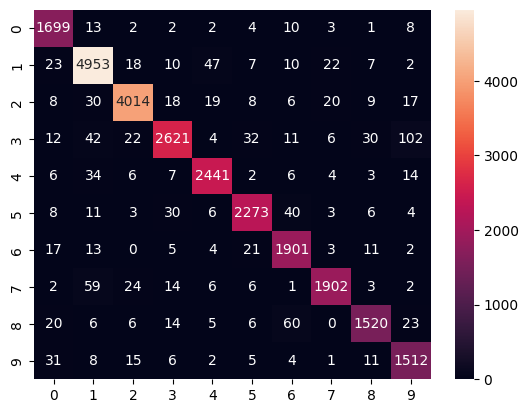

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        preds = model(imgs).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")


# Implementation with Pre-trained model

### Model VGG16

In [74]:
model_vgg = models.vgg16_bn(pretrained=True).to(DEVICE)

/home/pipe/venv/deepLearningvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pipe/venv/deepLearningvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [75]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Data transformation

In [76]:
# resize/crop + ImageNet normalization for VGG16.
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

In [77]:
train_transform_vgg = transforms.Compose([
    transforms.Resize(256),                # scale shorter side to 256
    transforms.RandomCrop(224),            # random 224×224 crop
    transforms.RandomHorizontalFlip(),     # small augmentation
    transforms.RandomRotation(10),  
    # Color jitter for brightness/contrast/saturation
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform_vgg = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),            # deterministic validation crop
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])


In [78]:
raw_ds_vgg = datasets.SVHN(
    root='./data', split='train', download=False,
    transform=transforms.ToTensor(),
    target_transform=svhn_label_transform
)

In [79]:
train_vgg, val_vgg = random_split(raw_ds_vgg, [train_size, val_size])

In [80]:
train_vgg.dataset.transform = train_transform_vgg
val_vgg.dataset.transform = val_transform_vgg


test_vgg  = datasets.SVHN(root='./data', split='test',  download=False,
                        transform=val_transform_vgg, target_transform=svhn_label_transform)

In [81]:
batch_size = 128
num_workers = 4   # use multiple CPU cores
pin_memory  = True  # faster GPU transfers

train_loader_vgg = DataLoader(train_vgg,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers,
                          pin_memory=pin_memory)

val_loader_vgg   = DataLoader(val_vgg,
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)

test_loader_vgg = DataLoader(test_vgg,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=pin_memory)

### Custom classification head 

we need to freeze the convolutional backbone of the pretrained model VGG16 so when optimizing only update the head (unfroze parameters) not the already pretrained weights of VGG16

In [82]:
for param in model_vgg.features.parameters():
    param.requires_grad = False

#### Replacement of the classifier head

In [83]:
model_vgg.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 256),           # reduce to 256 dims
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 10)                     # SVHN has 10 classes
)

In [84]:
model_vgg = model_vgg.to(DEVICE)

In [85]:
criterion_vgg = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_vgg = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_vgg.parameters()),
    lr=1e-3, 
    weight_decay=1e-4
)

#### Training loop

In [86]:
num_epochs = 15
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model_vgg, train_loader_vgg, optimizer_vgg, criterion_vgg, DEVICE)
    val_loss,   val_acc   = validate(model_vgg,   val_loader_vgg,   criterion_vgg, DEVICE)
    elapsed = time.time() - start

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_vgg.state_dict(), 'best_vgg16_svhn.pth')

    print(f"Epoch {epoch:02d}  "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}  "
          f"time={elapsed:.1f}s")

Epoch 01  Train: loss=1.3039, acc=0.6806  Val:   loss=1.0916, acc=0.7744  time=298.2s
Epoch 02  Train: loss=1.0818, acc=0.7866  Val:   loss=1.0524, acc=0.7965  time=296.3s
Epoch 03  Train: loss=1.0016, acc=0.8242  Val:   loss=1.0504, acc=0.7922  time=298.2s
Epoch 04  Train: loss=0.9479, acc=0.8501  Val:   loss=1.0412, acc=0.7997  time=296.6s
Epoch 05  Train: loss=0.9157, acc=0.8664  Val:   loss=1.0557, acc=0.7928  time=296.6s
Epoch 06  Train: loss=0.8908, acc=0.8780  Val:   loss=1.0513, acc=0.7939  time=296.6s
Epoch 07  Train: loss=0.8732, acc=0.8869  Val:   loss=1.0535, acc=0.7954  time=298.6s
Epoch 08  Train: loss=0.8626, acc=0.8935  Val:   loss=1.0766, acc=0.7855  time=296.8s
Epoch 09  Train: loss=0.8511, acc=0.8989  Val:   loss=1.0579, acc=0.7915  time=304.2s
Epoch 10  Train: loss=0.8449, acc=0.9017  Val:   loss=1.0705, acc=0.7928  time=307.3s
Epoch 11  Train: loss=0.8387, acc=0.9059  Val:   loss=1.0658, acc=0.7873  time=297.4s
Epoch 12  Train: loss=0.8307, acc=0.9089  Val:   loss=

In [87]:
model_vgg.load_state_dict(torch.load('best_vgg16_svhn.pth'))
test_loss, test_acc = validate(model_vgg, test_loader_vgg, criterion_vgg, DEVICE)
print(f"Final Test: loss={test_loss:.4f}, acc={test_acc:.4f}")

Final Test: loss=1.0630, acc=0.7848


### Model ResNet18

In [88]:
raw_ds_resnet = datasets.SVHN(
    root='./data', split='train', download=False,
    transform=transforms.ToTensor(), target_transform=svhn_label_transform
)
train_resnet, val_resnet = random_split(raw_ds_resnet, [train_size, val_size])

In [89]:
resnet_mean = [0.485, 0.456, 0.406]  # ImageNet stats
resnet_std  = [0.229, 0.224, 0.225]

In [90]:
train_resnet.dataset.transform = transforms.Compose([
    transforms.Resize(140),               # scale shorter side to 140
    transforms.RandomCrop(128),           # random 128×128 patch
    transforms.RandomHorizontalFlip(),    # small augmentation
    transforms.RandomRotation(10),  
    # Color jitter for brightness/contrast/saturation
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(resnet_mean, resnet_std)
])

val_resnet.dataset.transform = transforms.Compose([
    transforms.Resize(140),
    transforms.CenterCrop(128),           # deterministic evaluation crop
    transforms.ToTensor(),
    transforms.Normalize(resnet_mean, resnet_std)
])

In [91]:
test_resnet = datasets.SVHN(root='./data', split='test', download=False,
                       transform=val_resnet.dataset.transform, target_transform=svhn_label_transform)

In [92]:
batch_size = 128
num_workers = 4   # use multiple CPU cores
pin_memory  = True  # faster GPU transfers
train_loader_resnet = DataLoader(train_resnet, 
                          batch_size=batch_size, 
                          shuffle=True,  
                          num_workers=num_workers, 
                          pin_memory=pin_memory)
val_loader_resnet = DataLoader(val_resnet,   
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)
test_loader_resnet = DataLoader(test_resnet,  
                          batch_size=batch_size, 
                          shuffle=False, 
                          num_workers=num_workers, 
                          pin_memory=pin_memory)


In [93]:
model_resnet = models.resnet18(pretrained=True)

/home/pipe/venv/deepLearningvenv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [94]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

also here we freeze the early layers to only train the head

In [95]:
for name, param in model_resnet.named_parameters():
    if "layer3" not in name and "layer4" not in name and "fc" not in name:
        param.requires_grad = False

In [96]:
# Replace the fc: original maps 512 → 1000; we need 512 → 10
model_resnet.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 10)
)

In [97]:
model_resnet = model_resnet.to(DEVICE)

In [98]:
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(
    filter(lambda p: p.requires_grad, model_resnet.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

In [99]:
best_val_acc = 0.0
num_epochs   = 15

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc = train_one_epoch(model_resnet, train_loader_resnet, optimizer_resnet, criterion_resnet, DEVICE)
    val_loss,   val_acc   = validate(model_resnet, val_loader_resnet, criterion_resnet, DEVICE)
    elapsed = time.time() - start

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_resnet.state_dict(), 'best_resnet18_svhn.pth')

    print(f"Epoch {epoch:02d}  "
          f"Train: loss={train_loss:.4f}, acc={train_acc:.4f}  "
          f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}  "
          f"time={elapsed:.1f}s")

Epoch 01  Train: loss=0.6686, acc=0.7864  Val:   loss=0.3135, acc=0.9044  time=25.4s
Epoch 02  Train: loss=0.2415, acc=0.9298  Val:   loss=0.2753, acc=0.9178  time=25.1s
Epoch 03  Train: loss=0.1397, acc=0.9602  Val:   loss=0.2950, acc=0.9196  time=25.4s
Epoch 04  Train: loss=0.0807, acc=0.9769  Val:   loss=0.3161, acc=0.9202  time=26.6s
Epoch 05  Train: loss=0.0491, acc=0.9852  Val:   loss=0.3323, acc=0.9240  time=25.5s
Epoch 06  Train: loss=0.0371, acc=0.9880  Val:   loss=0.3641, acc=0.9194  time=26.3s
Epoch 07  Train: loss=0.0319, acc=0.9897  Val:   loss=0.3874, acc=0.9192  time=25.3s
Epoch 08  Train: loss=0.0259, acc=0.9922  Val:   loss=0.3988, acc=0.9196  time=26.0s
Epoch 09  Train: loss=0.0227, acc=0.9927  Val:   loss=0.4004, acc=0.9248  time=26.5s
Epoch 10  Train: loss=0.0187, acc=0.9941  Val:   loss=0.4092, acc=0.9221  time=26.6s
Epoch 11  Train: loss=0.0205, acc=0.9940  Val:   loss=0.3797, acc=0.9246  time=27.4s
Epoch 12  Train: loss=0.0171, acc=0.9944  Val:   loss=0.3905, acc

In [100]:
model_resnet.load_state_dict(torch.load('best_resnet18_svhn.pth'))
test_loss, test_acc = validate(model_resnet, test_loader_resnet, criterion_resnet, DEVICE)
print(f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}")

Test: loss=0.3669, acc=0.9263
